# Analyzing the gradients of the SHT

## Setup

In [1]:
import math
import numpy as np
import paddle
import paddle.nn as nn

import sys
sys.path.append("..")
from paddle_harmonics.quadrature import legendre_gauss_weights, clenshaw_curtiss_weights
from paddle_harmonics.legendre import legpoly, clm
from paddle_harmonics import RealSHT, InverseRealSHT

c:\Users\lixia\AppData\Local\anaconda3\envs\paddle310\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


## Problem setting

We consider the simple problem of fitting the spectral coefficients $\theta$ such that

$$
\begin{align}
\mathcal{L}
&= ||\mathop{\mathrm{ISHT}}[\theta] - u^*||^2_{S^2} \\
&\approx \sum_j \omega_j (\mathop{\mathrm{ISHT}}[\theta](x_j) - u^*(x_j))^2 \\
&= (S \, \theta - u^*)^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) \\
&= L
\end{align}
$$

is minimized.

The Vandermonde matrix $S$, which is characterized by $\mathop{\mathrm{ISHT}}[\theta] = S \theta$ realizes the action of the discrete SHT.

The necessary condition for a minimizer of $L$ is

$$
\begin{align}
& \nabla_\theta L = S^T \mathop{\mathrm{diag}}(\omega) \, (S \, \theta - u^*) = 0 \\
\Leftrightarrow \quad & S^T \mathop{\mathrm{diag}}(\omega) \, S \; \theta = S^T \mathop{\mathrm{diag}}(\omega) \, u^*.
\end{align}
$$

On the Gaussian grid, 

In [2]:
nlat = 64
nlon = 2*nlat
grid = "equiangular"

# for quadrature and plotting
if grid == "legendre-gauss":
    lmax = mmax = nlat
    xq, wq = legendre_gauss_weights(nlat)
elif grid =="equiangular":
    lmax = mmax = nlat//2
    xq, wq = clenshaw_curtiss_weights(nlat)

sht = RealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)
isht = InverseRealSHT(nlat, nlon, lmax=lmax, mmax=mmax, grid=grid)

lat = np.arccos(xq)
omega = math.pi * paddle.to_tensor(wq).astype(paddle.float32) / nlat
omega = omega.reshape((-1, 1))

nlon*omega.sum()

Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       12.56637001)

In [3]:
!wget https://astropedia.astrogeology.usgs.gov/download/Mars/GlobalSurveyor/MOLA/thumbs/Mars_MGS_MOLA_DEM_mosaic_global_1024.jpg -O ./data/mola_topo.jpg

import imageio.v3 as iio

img = iio.imread('./data/mola_topo.jpg')
#convert to grayscale
data = np.dot(img[...,:3]/255, [0.299, 0.587, 0.114])
# interpolate onto 512x1024 grid:
data = nn.functional.interpolate(paddle.to_tensor(data).unsqueeze(0).unsqueeze(0), size=(nlat,nlon)).squeeze()

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


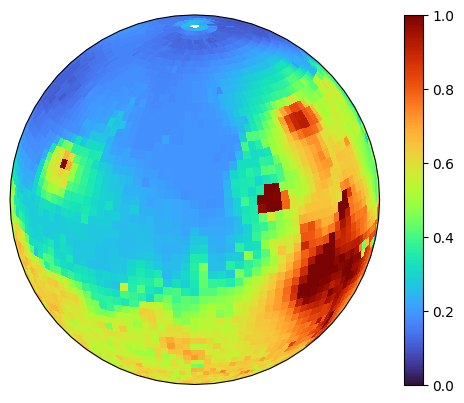

In [4]:
import matplotlib.pyplot as plt
from plotting import plot_sphere

plot_sphere(data, cmap="turbo", colorbar=True)

In [5]:
learning_rate = 1.0
theta_randn = paddle.randn(shape=(lmax, lmax), dtype=paddle.complex128).as_real()
theta = paddle.create_parameter(shape=theta_randn.shape, dtype=theta_randn.dtype, default_initializer=nn.initializer.Assign(theta_randn))
optim = paddle.optimizer.SGD(parameters=[theta], learning_rate=learning_rate)

for iter in range(40):
    optim.clear_grad()
    loss = paddle.sum(0.5 * omega * (isht(theta.as_complex()) - data) ** 2)
    loss.backward()

    # action of the Hessian
    with paddle.no_grad():
        for m in range(1, mmax):
            theta.grad[:, m] *= 0.5

    optim.step()

    print(f"iter: {iter}, loss: {loss}")

# for iter in range(40):
#     optim.zero_grad(set_to_none=True)
#     loss = torch.sum(0.5*omega*(isht(theta) - data)**2)
#     loss.backward()

#     # action of the Hessian
#     with torch.no_grad():
#         for m in range(1,mmax):
#             theta.grad[:,m].mul_(0.5)

#     with torch.no_grad():
#         theta.add_(theta.grad, alpha=-lr)

#     print(f"iter: {iter}, loss: {loss}")

iter: 0, loss: 501.2318117228774
iter: 1, loss: 0.008023963754357636
iter: 2, loss: 0.008023963754023318
iter: 3, loss: 0.008023963754023315
iter: 4, loss: 0.008023963754023316
iter: 5, loss: 0.008023963754023316
iter: 6, loss: 0.008023963754023316
iter: 7, loss: 0.008023963754023315
iter: 8, loss: 0.008023963754023315
iter: 9, loss: 0.008023963754023315
iter: 10, loss: 0.008023963754023316
iter: 11, loss: 0.008023963754023316
iter: 12, loss: 0.008023963754023315
iter: 13, loss: 0.008023963754023316
iter: 14, loss: 0.008023963754023316
iter: 15, loss: 0.008023963754023316
iter: 16, loss: 0.008023963754023315
iter: 17, loss: 0.008023963754023316
iter: 18, loss: 0.008023963754023316
iter: 19, loss: 0.008023963754023316
iter: 20, loss: 0.008023963754023316
iter: 21, loss: 0.008023963754023315
iter: 22, loss: 0.008023963754023315
iter: 23, loss: 0.008023963754023316
iter: 24, loss: 0.008023963754023315
iter: 25, loss: 0.008023963754023315
iter: 26, loss: 0.008023963754023316
iter: 27, loss

what's the best possible loss? $\theta^* = (S^T \mathop{\mathrm{diag}}(\omega) \, S)^{-1} S^T \mathop{\mathrm{diag}}(\omega) u^* = \mathop{\mathrm{SHT}}[u^*]$ gives us the global minimizer for this problem.

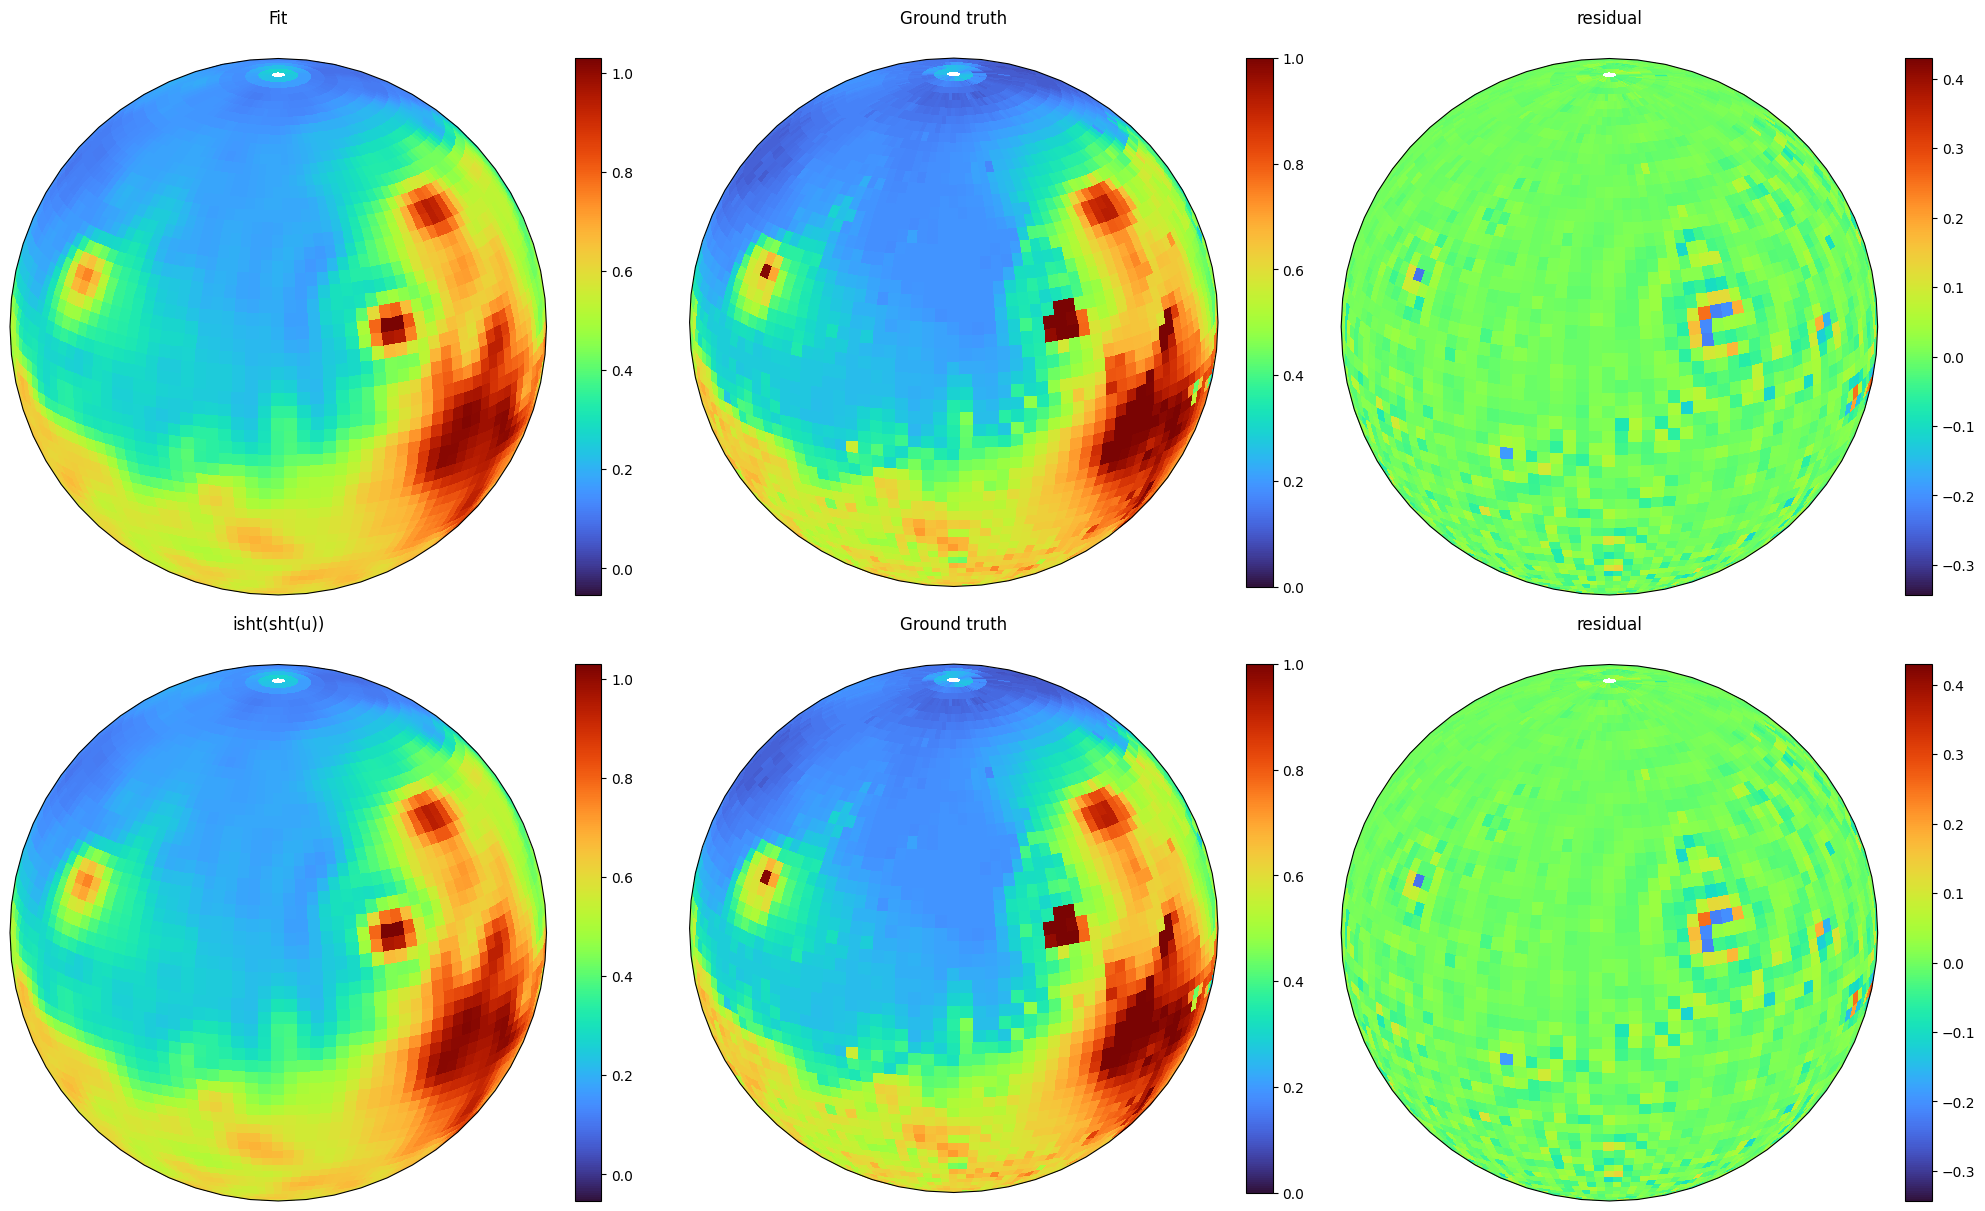

In [6]:
fig = plt.figure(layout="constrained", figsize=(20, 12))
subfigs = fig.subfigures(2, 3)

# spectral fitting
plot_sphere(
    isht(theta.as_complex()).detach(),
    fig=subfigs[0, 0],
    cmap="turbo",
    colorbar=True,
    title="Fit",
)
plot_sphere(data, fig=subfigs[0, 1], cmap="turbo", colorbar=True, title="Ground truth")
plot_sphere(
    (isht(theta.as_complex()) - data).detach(),
    fig=subfigs[0, 2],
    cmap="turbo",
    colorbar=True,
    title="residual",
)

# sht(u)
plot_sphere(
    isht(sht(data)).detach(),
    fig=subfigs[1, 0],
    cmap="turbo",
    colorbar=True,
    title="isht(sht(u))",
)
plot_sphere(data, fig=subfigs[1, 1], cmap="turbo", colorbar=True, title="Ground truth")
plot_sphere(
    (isht(sht(data)) - data).detach(),
    fig=subfigs[1, 2],
    cmap="turbo",
    colorbar=True,
    title="residual",
)